<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/binary/fasttext_binary_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://keras.io/zh/examples/imdb_fasttext/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score

In [ ]:
seed = 2021
ngram_range = 1 # if ngram_range=2 will add bi-grams features
input_dim = 5000
output_dim = 32
max_len = 500
batch_size = 128
epochs = 100
earlystopping_patience = 10

In [ ]:
# Load the dataset

(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=input_dim)

print(len(x_train), "train sequences")
print(len(x_valid), "test sequences")
print("Average train sequence length: {}".format(np.mean(list(map(len, x_train)), dtype=int)))
print("Average valid sequence length: {}".format(np.mean(list(map(len, x_valid)), dtype=int)))

17465344/17464789 [==============================] - 1s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


25000 train sequences
25000 test sequences
Average train sequence length: 238
Average valid sequence length: 230


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
# Preprocess the dataset


def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences


if ngram_range > 1:
    print("Adding {}-gram features".format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than input_dim in order
    # to avoid collision with existing features.
    start_index = input_dim + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # input_dim is the highest integer that could be found in the dataset.
    input_dim = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print("Average train sequence length: {}".format(np.mean(list(map(len, x_train)), dtype=int)))
    print("Average test sequence length: {}".format(np.mean(list(map(len, x_test)), dtype=int)))
    
x_train = pad_sequences(x_train, maxlen=max_len)
x_valid = pad_sequences(x_valid, maxlen=max_len)


In [ ]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # Training and validation loss
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

KFold: 1 starts.
Epoch 1/100
176/176 [==============================] - 5s 18ms/step - loss: 0.6901 - accuracy: 0.5637 - val_loss: 0.6761 - val_accuracy: 0.7209
Epoch 2/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6651 - accuracy: 0.7158 - val_loss: 0.6325 - val_accuracy: 0.7498
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6132 - accuracy: 0.7640 - val_loss: 0.5790 - val_accuracy: 0.7779
Epoch 4/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5591 - accuracy: 0.7948 - val_loss: 0.5286 - val_accuracy: 0.8074
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5037 - accuracy: 0.8245 - val_loss: 0.4844 - val_accuracy: 0.8274
Epoch 6/100
176/176 [==============================] - 3s 16ms/step - loss: 0.4583 - accuracy: 0.8495 - val_loss: 0.4471 - val_accuracy: 0.8428
Epoch 7/100
176/176 [==============================] - 3s 16ms/step - loss: 0.4219 - accuracy: 0.8607 - val_loss: 0.419

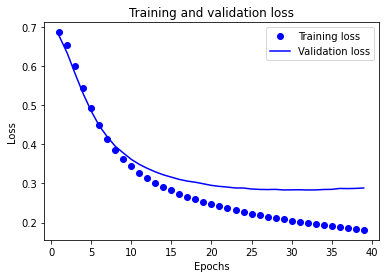

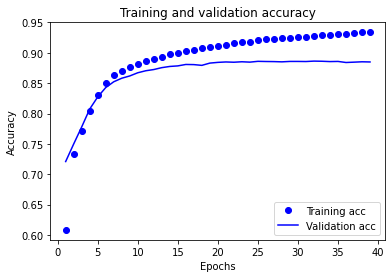

              precision    recall  f1-score   support

           0      0.884     0.888     0.886     12500
           1      0.887     0.884     0.886     12500

    accuracy                          0.886     25000
   macro avg      0.886     0.886     0.886     25000
weighted avg      0.886     0.886     0.886     25000


KFold: 2 starts.
Epoch 1/100
176/176 [==============================] - 3s 17ms/step - loss: 0.6898 - accuracy: 0.5825 - val_loss: 0.6744 - val_accuracy: 0.7271
Epoch 2/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6630 - accuracy: 0.7273 - val_loss: 0.6310 - val_accuracy: 0.7492
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6139 - accuracy: 0.7601 - val_loss: 0.5772 - val_accuracy: 0.7858
Epoch 4/100
176/176 [==============================] - 3s 15ms/step - loss: 0.5535 - accuracy: 0.8062 - val_loss: 0.5262 - val_accuracy: 0.8104
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5

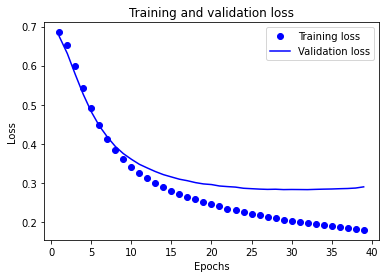

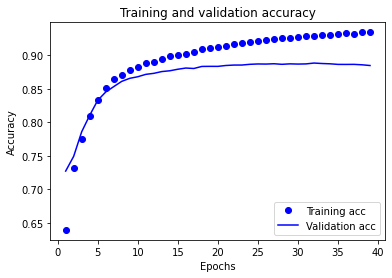

              precision    recall  f1-score   support

           0      0.896     0.876     0.886     12500
           1      0.878     0.899     0.888     12500

    accuracy                          0.887     25000
   macro avg      0.887     0.887     0.887     25000
weighted avg      0.887     0.887     0.887     25000


KFold: 3 starts.
Epoch 1/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6900 - accuracy: 0.5816 - val_loss: 0.6751 - val_accuracy: 0.7306
Epoch 2/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6639 - accuracy: 0.7244 - val_loss: 0.6311 - val_accuracy: 0.7549
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6126 - accuracy: 0.7656 - val_loss: 0.5791 - val_accuracy: 0.7628
Epoch 4/100
176/176 [==============================] - 3s 15ms/step - loss: 0.5564 - accuracy: 0.7945 - val_loss: 0.5273 - val_accuracy: 0.8099
Epoch 5/100
176/176 [==============================] - 3s 15ms/step - loss: 0.5

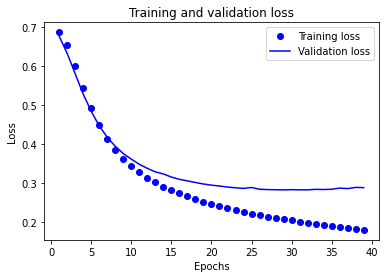

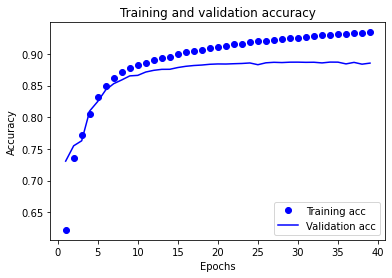

              precision    recall  f1-score   support

           0      0.894     0.879     0.886     12500
           1      0.881     0.895     0.888     12500

    accuracy                          0.887     25000
   macro avg      0.887     0.887     0.887     25000
weighted avg      0.887     0.887     0.887     25000


KFold: 4 starts.
Epoch 1/100
176/176 [==============================] - 4s 17ms/step - loss: 0.6901 - accuracy: 0.5630 - val_loss: 0.6747 - val_accuracy: 0.6396
Epoch 2/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6622 - accuracy: 0.6941 - val_loss: 0.6292 - val_accuracy: 0.7473
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6090 - accuracy: 0.7713 - val_loss: 0.5755 - val_accuracy: 0.7860
Epoch 4/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5529 - accuracy: 0.8016 - val_loss: 0.5251 - val_accuracy: 0.8051
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5

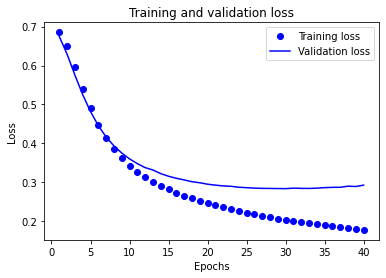

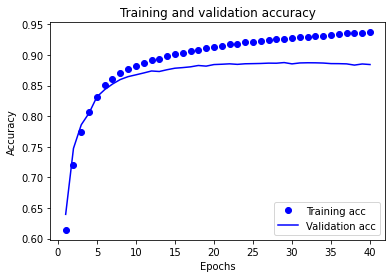

              precision    recall  f1-score   support

           0      0.896     0.872     0.884     12500
           1      0.875     0.899     0.887     12500

    accuracy                          0.885     25000
   macro avg      0.886     0.885     0.885     25000
weighted avg      0.886     0.885     0.885     25000


KFold: 5 starts.
Epoch 1/100
176/176 [==============================] - 4s 17ms/step - loss: 0.6900 - accuracy: 0.5360 - val_loss: 0.6752 - val_accuracy: 0.6341
Epoch 2/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6636 - accuracy: 0.7057 - val_loss: 0.6311 - val_accuracy: 0.7514
Epoch 3/100
176/176 [==============================] - 3s 17ms/step - loss: 0.6123 - accuracy: 0.7658 - val_loss: 0.5781 - val_accuracy: 0.7829
Epoch 4/100
176/176 [==============================] - 3s 17ms/step - loss: 0.5545 - accuracy: 0.8047 - val_loss: 0.5281 - val_accuracy: 0.8102
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5

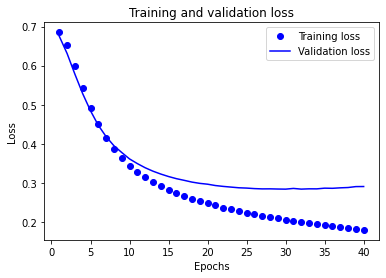

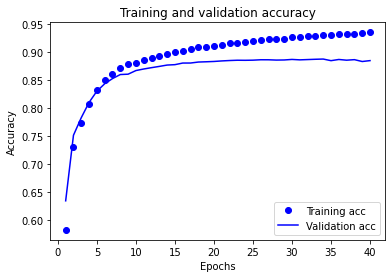

              precision    recall  f1-score   support

           0      0.888     0.886     0.887     12500
           1      0.886     0.889     0.887     12500

    accuracy                          0.887     25000
   macro avg      0.887     0.887     0.887     25000
weighted avg      0.887     0.887     0.887     25000


KFold: 6 starts.
Epoch 1/100
176/176 [==============================] - 4s 17ms/step - loss: 0.6899 - accuracy: 0.5738 - val_loss: 0.6740 - val_accuracy: 0.6582
Epoch 2/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6616 - accuracy: 0.7070 - val_loss: 0.6280 - val_accuracy: 0.7606
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6093 - accuracy: 0.7677 - val_loss: 0.5744 - val_accuracy: 0.7814
Epoch 4/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5541 - accuracy: 0.7979 - val_loss: 0.5245 - val_accuracy: 0.8070
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5

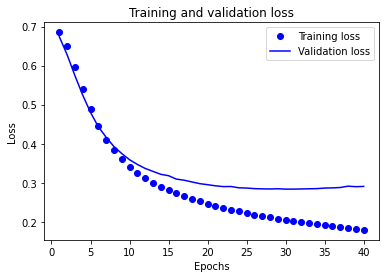

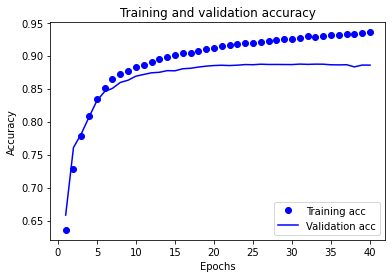

              precision    recall  f1-score   support

           0      0.886     0.887     0.886     12500
           1      0.887     0.886     0.886     12500

    accuracy                          0.886     25000
   macro avg      0.886     0.886     0.886     25000
weighted avg      0.886     0.886     0.886     25000


KFold: 7 starts.
Epoch 1/100
176/176 [==============================] - 4s 18ms/step - loss: 0.6893 - accuracy: 0.5749 - val_loss: 0.6728 - val_accuracy: 0.7080
Epoch 2/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6608 - accuracy: 0.7054 - val_loss: 0.6270 - val_accuracy: 0.7594
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6084 - accuracy: 0.7675 - val_loss: 0.5735 - val_accuracy: 0.7883
Epoch 4/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5505 - accuracy: 0.8057 - val_loss: 0.5230 - val_accuracy: 0.8142
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.4

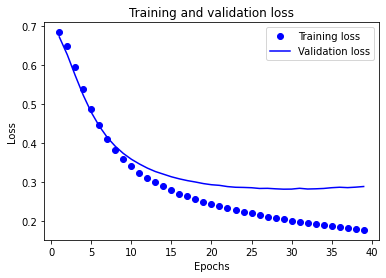

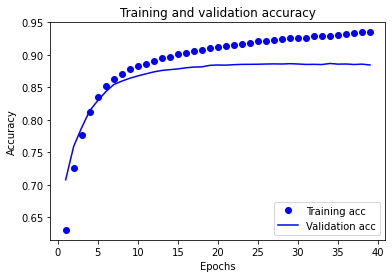

              precision    recall  f1-score   support

           0      0.889     0.883     0.886     12500
           1      0.884     0.890     0.887     12500

    accuracy                          0.887     25000
   macro avg      0.887     0.887     0.887     25000
weighted avg      0.887     0.887     0.887     25000


KFold: 8 starts.
Epoch 1/100
176/176 [==============================] - 3s 17ms/step - loss: 0.6897 - accuracy: 0.5781 - val_loss: 0.6739 - val_accuracy: 0.6508
Epoch 2/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6614 - accuracy: 0.7264 - val_loss: 0.6285 - val_accuracy: 0.7605
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6106 - accuracy: 0.7736 - val_loss: 0.5746 - val_accuracy: 0.7900
Epoch 4/100
176/176 [==============================] - 3s 16ms/step - loss: 0.5545 - accuracy: 0.8004 - val_loss: 0.5256 - val_accuracy: 0.8013
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.4

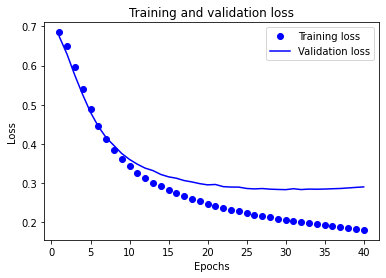

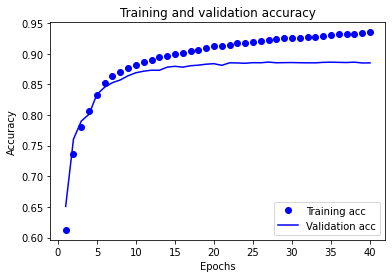

              precision    recall  f1-score   support

           0      0.891     0.879     0.885     12500
           1      0.880     0.892     0.886     12500

    accuracy                          0.886     25000
   macro avg      0.886     0.886     0.886     25000
weighted avg      0.886     0.886     0.886     25000


KFold: 9 starts.
Epoch 1/100
176/176 [==============================] - 4s 18ms/step - loss: 0.6898 - accuracy: 0.5586 - val_loss: 0.6741 - val_accuracy: 0.7161
Epoch 2/100
176/176 [==============================] - 3s 17ms/step - loss: 0.6625 - accuracy: 0.7203 - val_loss: 0.6296 - val_accuracy: 0.7468
Epoch 3/100
176/176 [==============================] - 3s 17ms/step - loss: 0.6106 - accuracy: 0.7648 - val_loss: 0.5767 - val_accuracy: 0.7741
Epoch 4/100
176/176 [==============================] - 3s 17ms/step - loss: 0.5529 - accuracy: 0.7991 - val_loss: 0.5253 - val_accuracy: 0.8106
Epoch 5/100
176/176 [==============================] - 3s 17ms/step - loss: 0.5

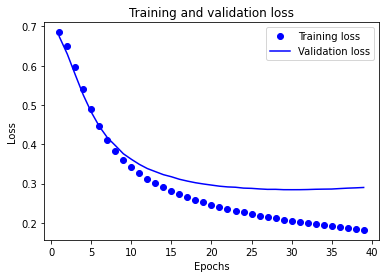

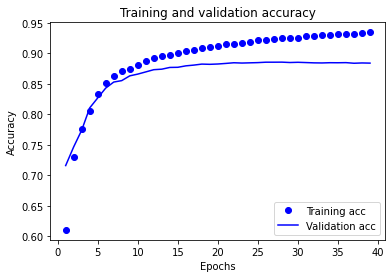

              precision    recall  f1-score   support

           0      0.887     0.883     0.885     12500
           1      0.883     0.887     0.885     12500

    accuracy                          0.885     25000
   macro avg      0.885     0.885     0.885     25000
weighted avg      0.885     0.885     0.885     25000


KFold: 10 starts.
Epoch 1/100
176/176 [==============================] - 4s 17ms/step - loss: 0.6905 - accuracy: 0.5659 - val_loss: 0.6770 - val_accuracy: 0.6925
Epoch 2/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6660 - accuracy: 0.7028 - val_loss: 0.6340 - val_accuracy: 0.7581
Epoch 3/100
176/176 [==============================] - 3s 16ms/step - loss: 0.6158 - accuracy: 0.7681 - val_loss: 0.5799 - val_accuracy: 0.7803
Epoch 4/100
176/176 [==============================] - 3s 17ms/step - loss: 0.5582 - accuracy: 0.8002 - val_loss: 0.5282 - val_accuracy: 0.8101
Epoch 5/100
176/176 [==============================] - 3s 16ms/step - loss: 0.

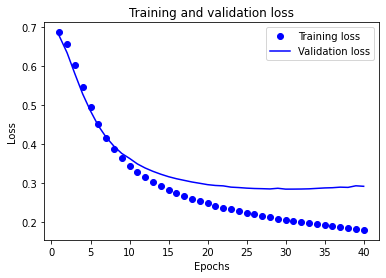

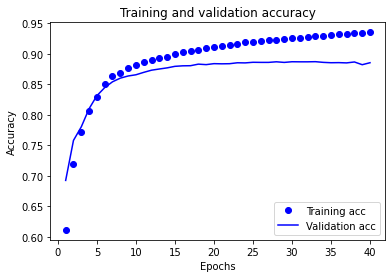

              precision    recall  f1-score   support

           0      0.892     0.881     0.886     12500
           1      0.882     0.893     0.888     12500

    accuracy                          0.887     25000
   macro avg      0.887     0.887     0.887     25000
weighted avg      0.887     0.887     0.887     25000


Average accuracy: 0.8907 (+/- 0.0038)
Average loss: 0.2809 (+/- 0.0065)
Average F1: 0.8869 (+/- 0.0010)


In [ ]:
# Create and train the model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
cv_acc = []
cv_loss = []
cv_f1 = []
n = 1
for train, valid in kfold.split(x_train, y_train):

  print("KFold: {} starts.".format(n))
  model = Sequential([
    # We start off with an efficient embedding layer which maps our vocab indices into embedding_dims dimensions
    Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_len),
    # We add a GlobalAveragePooling1D, which will average the embeddings of all words in the document
    GlobalAveragePooling1D(),
    # Output layer
    Dense(units=1, activation="sigmoid")
  ])

  model.compile(
      loss="binary_crossentropy",
      optimizer="adam",
      metrics=["accuracy"]
  )

  # model.summary()

  history = model.fit(
      x=x_train[train],
      y=y_train[train],
      validation_data=(x_valid, y_valid),
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      callbacks=[earlystop_callback]
  )

  loss, acc = model.evaluate(x=x_train[valid], y=y_train[valid], verbose=1)
  cv_acc.append(acc)
  cv_loss.append(loss)

  plot_perf(history)

  # np.argmax(model.predict(x), axis=-1), if your model does multi-class classification (e.g. if it uses a softmax last-layer activation).
  # (model.predict(x) > 0.5).astype("int32"), if your model does binary classification (e.g. if it uses a sigmoid last-layer activation).
  y_pred = (model.predict(x_valid) > 0.5).astype("int32")
  report = classification_report(y_true=y_valid, y_pred=y_pred, digits=3, output_dict=False)
  print(report)

  f1 = f1_score(y_true=y_valid, y_pred=y_pred, average="binary")
  cv_f1.append(f1)

  print("")
  n += 1

print("Average accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_acc), np.std(cv_acc)))
print("Average loss: {:.4f} (+/- {:.4f})".format(np.mean(cv_loss), np.std(cv_loss)))
print("Average F1: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1), np.std(cv_f1)))
